# Greedy Heuristics: Traveling Salesman Problem

---

**Greedy heuristics** are very commonly used approaches for solving **combinatorial optimisation** problems.

In this tutorial, we will introduce some common greedy heuristics to solve the **Traveling Salesman Problem (TSP)**, which is a well-known complex **combinatorial optimisation** problem with many applications in domains such as logistics, supply chain and electric engineering.

## Printed Circuit Board Drilling

---

Consider the Printed Circuit Board (PCB) drilling problem, where we need to drill holes in the printed circuit board. Usually, there are hundreds of holes to be drilled on the PCB, and we have to use a driller to drill the holes one by one. Specifically, starting from its initial position, the driller moves to the first hole and drill it, and move to the next, and so on.


<img src="img/pcb-drilling.jpeg" width=500 />

This PCB driling problem can be seen as a TSP, which is to find the **shortest path** (in terms straight-line/Euclidean distance) to drill all the holes. An example containing 280 holes (the `a280.tsp` instance in the [TSPLIB](http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp/) page) along with its optimal solution is shown below. Its total cost is 2579.

<img src="img/tsp-a280-opt.png" width=400 />

## Traveling Salesman Problem

---

A formal definition of TSP is as follows. Given a set of nodes $\{v_1, ..., v_n\}$ and the cost $c(v_i,v_j)$ from each node $v_i$ to another node $v_j$ ($1 \leq i \neq j \leq n$), the problem is to find a tour with the **minimal total cost** so that

- The tour visits **each node exactly once**, and
- The tour is a **cycle**.

In other words, TSP is to find a **[Hamiltonian Cycle](https://en.wikipedia.org/wiki/Hamiltonian_path)** with the minimal total cost. TSP is known to be NP-complete, and no polynomial-time algorithm can solve it to optimality.

Below we give the code to read/load a `.tsp` file (available from the [TSPLIB](http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp/) page), which contains a set of nodes with their [x, y] coordinates.

In [1]:
def load_data(file):

    """
    Read a TSP instance from a .tsp file, and returns the coordinates of the points.

    :param file: the .tsp file.
    :return: coord
    """

    f = open(file, "r")
    
    # Skip the first information rows until "NODE_COORD_SECTION" is seen
    line = f.readline()
    while not line.__contains__("NODE_COORD_SECTION"):
        line = f.readline()

    # Read the coordinate section
    coord = {}

    line = f.readline()
    while not line.__contains__("EOF"):
        line_elements = line.split()
        id = int(line_elements[0])
        x = float(line_elements[1])
        y = float(line_elements[2])
        coord[id] = [x, y]
        line = f.readline()

    f.close()

    return coord

Based on the coordinates of the nodes, we can calculate the **cost matrix**, which is defined as the **Euclidean distance matrix** (rounded to integers) as follows.

In [2]:
import numpy as np
import math

def euclidean_distance_matrix(coord):
    """
    Calculate the Euclidean distance matrix based on the coordinates.
    """
    
    id_list = list(coord.keys())
    
    dist_mtx = np.zeros((max(id_list)+1, max(id_list)+1))
    for id1 in coord.keys():
        [x1, y1] = coord[id1]
        for id2 in coord.keys():
            if id1 == id2:
                continue
            
            [x2, y2] = coord[id2]
            dist = round(math.sqrt((x2 - x1) * (x2 - x1) + (y2 - y1) * (y2 - y1)))
            dist_mtx[id1, id2] = dist
    
    return dist_mtx

We can read the `a280.tsp` drilling problem instance and show the coordinates of the first 5 nodes below (there are 280 in total).

In [3]:
coord = load_data("data/a280.tsp")

for count, id in enumerate(coord):
    if count == 5:
        break
    print(f"node {id}: [x, y] = {coord[id]}") 

node 1: [x, y] = [288.0, 149.0]
node 2: [x, y] = [288.0, 129.0]
node 3: [x, y] = [270.0, 133.0]
node 4: [x, y] = [256.0, 141.0]
node 5: [x, y] = [256.0, 157.0]


We then calculate the Euclidean distanc matrix from the coordinates and print the matrix below.

In [4]:
cost_mtx = euclidean_distance_matrix(coord)

print(cost_mtx)

[[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0. 20. ... 43. 34. 18.]
 [ 0. 20.  0. ... 36. 28.  9.]
 ...
 [ 0. 43. 36. ...  0.  9. 29.]
 [ 0. 34. 28. ...  9.  0. 20.]
 [ 0. 18.  9. ... 29. 20.  0.]]


## Greedy Heuristics

---

The main idea of **greedy heuristics** is to construct the solution step by step. At each iteration, it selects the most **greedy** step. We introduce two common heuristics for TSP.

1. **Nearest Neighbour Heuristic**
2. **Insertion Heuristic**

## Nearest Neighbour Heuristic

---

The nearest neighbour heuristic constructs a TSP tour as follows. 

1. Initially, it starts at an arbitrary node. 
2. At each step, it finds the **nearest neighbour** of the current node (the last node of the tour), and append it to the end of the tour. 
3. The heuristic repeats the step 2 above until all the nodes have been appended to the tour. Finally it inserts an edge from the last node of the tour to the start node to form a cycle.

Below shows the code of the nearest neighbour heuristic.

> **NOTE**: Here the first node (id 1) is arbitrarily selected as the start node. Note that different start nodes may lead to different solutions.

In [5]:
def nearest_neighbour_tsp(node_ids, cost_mtx):
    '''
    The nearest neighbour heuristic to solve TSP.
    '''    
    
    start_node = node_ids[0] # Arbitrarily select the first node as the start node
    tour = [start_node] # The tour starts from the node
    remaining_nodes = list(node_ids[1:]) # The remaining nodes to be added, initially exclude the first start node
    
    while len(remaining_nodes) > 0:
        curr_node = tour[-1]
        next_node = None
        min_dist = float('inf')
        
        # Find the nearest neighbour from the remaining nodes with the min cost from curr_node
        for node in remaining_nodes:
            if cost_mtx[curr_node, node] < min_dist:
                next_node = node
                min_dist = cost_mtx[curr_node, node]

        # Append the next node to the tour and remove it from the remaining nodes
        tour.append(next_node)
        remaining_nodes.remove(next_node)
    
    # Finally form a cycle
    tour.append(start_node)
    
    return np.array(tour)

Now we obtain a solution of the `a280.tsp` instance by the near neighbour heuristic as follows. We can see the obtained `nn_tour` starts and ends at node 1, and visits each node exactly ones.

In [6]:
nn_tour = nearest_neighbour_tsp(list(coord.keys()), cost_mtx)

print(nn_tour)

[  1 280   2   3 279 278   4 277 276 275 274 273 272 271  16  17  18  19
  20  21 128 127 126 125  30  31  32  29  28  27  26  22  25  23  24  14
  13  12  11  10   8   7   9   6   5 260 259 258 257 254 253 208 207 210
 209 252 255 256 249 248 247 244 241 240 239 238 231 232 233 234 235 236
 237 246 245 243 242 250 251 230 229 228 227 226 225 224 223 222 219 218
 215 214 211 212 213 216 217 220 221 203 202 200 144 143 142 141 140 139
 138 137 136 135 134 270 269 268 267 266 265 264 263 262 261  15 133 132
 131 130 129 154 155 153 156 152 151 177 176 181 180 179 178 150 149 148
 147 146 145 199 198 197 194 195 196 201 193 192 191 190 189 188 187 185
 184 183 182 161 162 163 164 165 166 167 168 169 101 100  99  98  93  94
  95  96  97  92  91  90  89  81  80  79  76  75  74  73  72  71  70  67
  66  65  64  63  62 118  61  60  43  42  41  40  39  38  37  36  35  34
  33 124 123 122 121 120 119 157 158 159 160 175 174 173 106 105 104 103
 102 170 171 172 107 108 109 110 111 112  88  83  8

### Worse-case Performance

The tour cost obtained by the nearest neighbour heuristic has the following bound:

$$
\frac{c(\mathtt{NN})}{c(\mathtt{OPT})} \leq \frac{1}{2}\lceil \log_2 n \rceil + \frac{1}{2}.
$$

The bound increases with the increase of the problem size. However, the practical performance of the nearest neighbour heuristic is often much better than the worst case.

> **NOTE**: This is obtain from [here](https://ocw.mit.edu/courses/civil-and-environmental-engineering/1-203j-logistical-and-transportation-planning-methods-fall-2006/lecture-notes/lec16.pdf).

### Computational Complexity

The computational complexity of the nearest neighbour heuristic is $O(n^2)$, where $n$ is the number of nodes. 

We can see that the heuristic has $n-1$ steps of appending nodes. At each step, we need to make $R$ distance comparisons, where $R$ is the number of remaining nodes. Thus, the complexity is

$$
(n-1) + (n-2) + \dots + 1 = O(n^2).
$$

## Insertion Heuristic

---

The **insertion heuristic** starts with a sub-tour that visits a subset of nodes. Then, at each step, it inserts a remaining node into a position of the sub-tour. The above step is repeated until all the nodes have been inserted into the tour.

In the insertion heuristic, there are three important design issues.

1. How to construct the **initial sub-tour**?
2. How to **select the next remaining node** to be inserted?
3. Where to **insert the next node**?

### Initial Sub-tour 

An intuitive initial sub-tour consists of two nodes. For simplicity, we can select the edge $[a, b]$ with the largest distance, and set the initial sub-tour as $[a, b, a]$.

### Select and Insert Next Remaining Node

By following the greedy heuristic, we can select the next remaining node and its insertion position greedily. Specifically, we enumerate all the remaining node and all the possible insertion positions, and select the node and insertion position that leads to the **lowest increase** of the tour cost.

> **NOTE**: This version is the so-called **Cheapest Insertion Heuristic**. There can be other types of insertion heuristics with different schemes for selecting and inserting the next node.

Below is the code of the insertion heuristic.

In [7]:
def insertion_heuristic_tsp(node_ids, cost_mtx):
    '''
    The insertion heuristic to solve TSP.
    '''    
    
    # Find the longest edge (a, b)
    (rows, columns) = np.where(cost_mtx == np.max(cost_mtx))
    a, b = rows[0], columns[0]
    
    tour = [a, b, a]
    
    remaining_nodes = list(node_ids)
    remaining_nodes.remove(a)
    remaining_nodes.remove(b)
    
    while len(remaining_nodes) > 0:
        next_node = None
        next_idx = None
        min_insert_cost = float('inf')
        
        # Find the node and insertion position with the least insertion cost
        for node in remaining_nodes:
            for i in range(1, len(tour)):
                insert_cost = cost_mtx[tour[i-1], node] + cost_mtx[node, tour[i]] - cost_mtx[tour[i-1], tour[i]]
                
                if insert_cost < min_insert_cost:
                    next_node = node
                    next_idx = i
                    min_insert_cost = insert_cost
        
        # Insert the next node and remove from the remaining nodes
        tour.insert(next_idx, next_node)
        remaining_nodes.remove(next_node)
    
    
    return np.array(tour)       

We apply the insertion heuristic to obtain a solution to the `a280` drilling problem as follows.

In [8]:
ih_tour = insertion_heuristic_tsp(list(coord.keys()), cost_mtx)
print(ih_tour)

[  1   3   4   5   6   7   8  10   9  11  12  13  14  15  16 271 272 273
 274 275 276 277 279 278 259 260 261 262 263 264 268 269 270 134 135 136
 137 267 266 138 150 178 151 177 152 156 153 155 154 129 130 131 132 133
  17  18  19  20  21 128 127 126  29  24  23  25  22  26  27  28  32  33
  34  31  30 125 124 123 122 121 120 119 157 158 159 160 107 105 104 108
 110 111 114 112  88 113  87 115 117 118  59  58  57  44  45  56  55  46
  47  54  53  48  49  52  51  50  38  37  36  35  39  40  41  42  43  60
  61 116  86  65  62  63  64  68  69  67  70  71  72  73  74  75  77  78
  76  66  85  84  83  82 109  89  90  91  80  81  79  94  95  96  97  98
  93  92  99 100 101 169 102 103 106 173 174 172 171 170 168 167 166 165
 164 163 162 161 175 187 188 189 190 191 192 193 186 185 184 183 182 181
 176 180 179 149 148 147 146 145 199 198 197 194 195 196 201 202 203 204
 200 144 143 142 141 139 140 265 258 257 254 256 255 253 208 206 205 207
 212 213 216 217 220 221 222 219 218 215 214 211 21

### Worse-case Performance

The tour cost obtained by the cheapest insertion heuristic has the following bound:

$$
\frac{c(\mathtt{IH})}{c(\mathtt{OPT})} < 2.
$$

In other words, the tour cost obtained by the cheapest insertion heuristic is less than twice as the optimal cost. This, of course, is a very loose bound. In practice, the performance is often much better than the worst case.

> **NOTE**: This is obtain from [here](https://ocw.mit.edu/courses/civil-and-environmental-engineering/1-203j-logistical-and-transportation-planning-methods-fall-2006/lecture-notes/lec16.pdf).

### Computational Complexity

The computational complexity of the above implementation of insertion heuristic is $O(n^3)$.

It has $n-2$ steps of inserting the nodes. At step $k$, there are $k+1$ nodes in the tour ($k+1$ possible insertion positions), and $n-k-1$ remaining nodes (e.g., at step $1$, there are $2$ nodes in the tour and $n-2$ remaining nodes). Thus, there are $(n-k-1)\times (k+1)$ comparisons at step $k$. The total computational complexity is

$$
(n-2) \times 2 + (n-3) \times 3 + \dots + (n-k) \times k + \dots + 1 \times (n-1) = O(n^3).
$$

> **NOTE**: with careful programming, the complexity can be reduced to $O(n^2\log n)$.

## Evaluation

---

To evaluate the solutions obtained by the greedy heuristics, we define methods for the following two purposes:

1. **Calcuate the tour cost**: this is the ultimate goal of TSP, which is the minimise the tour cost.
2. **Plot the tour**: this is to visualise the tour in the 2D plane, to help understand why the tour is good/bad.

### Calculate Tour Cost

We define a method to **calculate the cost** of a tour (sum of all the edge costs in the tour) as follows.

In [9]:
def calc_tour_cost(tour, cost_mtx):
    return sum([cost_mtx[tour[i], tour[i+1]] for i in range(len(tour)-1)])

### Plot Tour

We define the following method to plot the tour in a 2D plane, using the `matplotlib` library.

In [10]:
import matplotlib.pyplot as plt

def plot_tour(tour, coord, title):
    """
    Function for visualise a TSP tour on a 2D figure.

    :param tour: The TSP tour, which is a list of nodes.
    :param coord: Dictionary of {id: [x, y]} coordinates for each node.
    :param title: Plot title.
    """
    
    px = [coord[id][0] for id in coord.keys()]
    py = [coord[id][1] for id in coord.keys()]

    # Set axis too slightly larger than the set of x and y
    min_x, max_x, min_y, max_y = min(px), max(px), min(py), max(py)
    center_x = (min_x + max_x) / 2
    center_y = (min_y + max_y) / 2

    width = (max(px) - min(px)) * 1.1
    height = (max(py) - min(py)) * 1.1

    min_x = center_x - width / 2
    max_x = center_x + width / 2
    min_y = center_y - height / 2
    max_y = center_y + height / 2

    plt.xlim(min_x, max_x)
    plt.ylim(min_y, max_y)
    
    # Plot the [px, py] points
    for [x, y] in coord.values():
        plt.plot(x, y, 'co', markersize = 5)
    
    # Plot the tour
    for i in range(0, len(tour)-1):
        [x1, y1], [x2, y2] = coord[tour[i]], coord[tour[i + 1]]
        plt.plot([x1, x2], [y1, y2], color = 'c')

    plt.title(title)
    plt.show()

Now we calculate the cost of the `nn_tour` obtained by the nearest neighbour heuristic, and plot it.

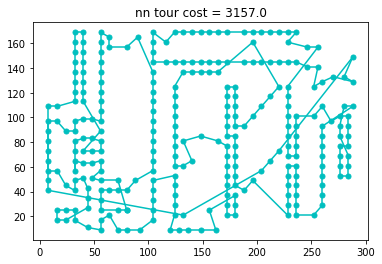

In [11]:
nn_tc = calc_tour_cost(nn_tour, cost_mtx)
plot_tour(nn_tour, coord, "nn tour cost = " + str(nn_tc))

We do the same for the insertion heuristic as follows.

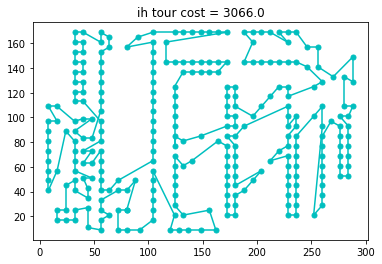

In [12]:
ih_tc = calc_tour_cost(ih_tour, cost_mtx)
plot_tour(ih_tour, coord, "ih tour cost = " + str(ih_tc))

We can see that the insertion heuristic can obtain better solution than the nearest neighbour heuristic (3066 vs 3157). We can also see that the `nn_tour` can have very long links, as some nodes could be missed in its region during the nearest neighbour heuristic, and have to be linked back from a very distant node. In contrast, the insertion heuristic can avoid such long links.

## Summary

---

In this tutorial, we introduced two greedy heuristics for TSP, i.e., the nearest neighbour heuristic and the insertion heuristic. Both heuristics construct a solution step by step, and make greedy decisions at each step.

### Nearest Neighbour Heuristic vs Insertion Heuristic

- The nearest neighbour heuristic tends to leave some nodes isolated, which causes long links and poor solution quality. The insertion heuristic can avoid such long links. As a result, the insertion heuristic tends to be better than the nearest neighbour heuristic, although we cannot guarantee it is always the case.
- The nearest neighbour heuristic is faster than the insertion heuristic: complexity $O(n^2)$ vs $O(n^2\log n)$.

Both greedy heuristics are much worse than the optimal solution. To further improve the solution, we can use advanced solution optimisation methods such as local search, simulated annealing, tabu search, genetic algorithms, etc.

---

- More tutorials can be found [here](https://github.com/meiyi1986/tutorials).
- [Yi Mei's homepage](https://meiyi1986.github.io/)